In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/ICECCME/test.zip -d /content/drive/MyDrive/ICECCME/test

In [ ]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image as PilImage
from typing import Tuple
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import L2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# working directories
WORKDIR = os.path.abspath('/content/drive/MyDrive/ICECCME/test') # get the path of this file - image metadata
DATA = os.path.abspath('/content/drive/MyDrive/ICECCME/')

MAXBIT= os.path.join(WORKDIR, 'maxbit')
MINMAX= os.path.join(WORKDIR, 'minmax')
PERCENTILE= os.path.join(WORKDIR, 'percentile')
MAXPEAK = os.path.join(WORKDIR, 'maxpeak')
WINDOWCROP= os.path.join(WORKDIR, 'windowcrop')
PREDICTED_IMAGE = os.path.join(WORKDIR, 'predicted_image')
PREDICTED_METADATA = os.path.join(WORKDIR, 'predicted_metadata')


ORIGINALPNG = os.path.join(WORKDIR, 'orig')

MAXCENTER = 32767.0
MAXWIDTH = 65535.0

In [ ]:
import numpy as np
def window_crop(img, center, width):
    max_pixel_intensity = 255.0
    retval = np.piecewise(
        img,
        [
            # conditions to check
            img <= (center - (width / 2)),
            img > (center + (width / 2))
        ],
        [  # what to apply on each condition
            0,  # where first condition true
            max_pixel_intensity,  # where second condition true
            lambda img: (  # where none of the conditions are true
                (img - center + width / 2) / width * max_pixel_intensity
            )
        ]
    )

    return retval

def min_max_scaling(img):
    max_pixel_intensity = 255.0
    lower_bound = np.min(img[np.nonzero(img)])
    upper_bound = np.max(img)
    center = (upper_bound - lower_bound) / 2 + lower_bound
    width = upper_bound - lower_bound
    retval = np.piecewise(
        img,
        [
            # conditions to check
            img <= lower_bound,
            img > upper_bound
        ],
        [  # what to apply on each condition
            0,  # where first condition true
            max_pixel_intensity,  # where second condition true
            lambda img: (  # where none of the conditions are true
                (img - center + width / 2) / width * max_pixel_intensity
            )
        ]
    )
    return retval

def percentile_scaling(img):
    max_pixel_intensity = 255.0
    lower_bound = np.percentile(img.ravel(), 10)
    upper_bound = np.percentile(img.ravel(), 90)
    center = (upper_bound - lower_bound) / 2 + lower_bound
    width = upper_bound - lower_bound
    retval = np.piecewise(
        img,
        [
            # conditions to check
            img <= lower_bound,
            img > upper_bound
        ],
        [  # what to apply on each condition
            0,  # where first condition true
            max_pixel_intensity,  # where second condition true
            lambda img: (  # where none of the conditions are true
                (img - center + width / 2) / width * max_pixel_intensity
            )
        ]
    )
    return retval

def denoise_image(image):
    # Sets pixel intensities that appear in less than 25th percentile to 0
    hist, bins = np.histogram(image.ravel(), image.max())
    threshold = np.percentile(hist, 25)

    for i in range(len(hist)):
        if hist[i] < threshold:
            hist[i] = 0

    return hist

def max_peak_scaling(img):
    max_pixel_intensity = 255
    search_size = 32
    denoised = denoise_image(img)

    lower_bound = 0
    counter = 0
    for i in range(len(denoised)):
        if (denoised[i] != 0):
            counter += 1
        else:
            counter = 0
        if (counter == 1):
            lower_bound = i
        if (counter >= 10):
            break

    upper_bound = 0
    counter = 0
    for i in range(len(denoised) - 1, 0, -1):
        if (denoised[i] != 0):
            counter += 1
        else:
            counter = 0
        if (counter == 1):
            upper_bound = i
        if (counter >= 10):
            break

    if (lower_bound > upper_bound):
        temp = lower_bound
        lower_bound = upper_bound
        upper_bound = temp

    if (upper_bound != lower_bound):
        if (lower_bound + search_size < upper_bound):
            offset = np.where(denoised[lower_bound:lower_bound+search_size] == denoised[lower_bound:lower_bound+search_size].max())[0][0]
            lower_bound += offset
            offset = np.where(denoised[upper_bound-search_size:upper_bound] == denoised[upper_bound-search_size:upper_bound].max())[0][0]
            upper_bound = upper_bound - search_size + offset
    else:
        lower_bound = 0
        upper_bound = len(denoised)

    center = (upper_bound - lower_bound) / 2 + lower_bound
    width = upper_bound - lower_bound
    retval = np.piecewise(
        img,
        [
            # conditions to check
            img <= lower_bound,
            img > upper_bound
        ],
        [  # what to apply on each condition
            0,  # where first condition true
            max_pixel_intensity,  # where second condition true
            lambda img: (  # where none of the conditions are true
                (img - center + width / 2) / width * max_pixel_intensity
            )
        ]
    )
    return retval

In [ ]:
def scale_image(image):
    train_means = 57.33223588599136
    train_stddev = 64.42799224651517
    return (image - train_means) / train_stddev

In [ ]:
# image preprocessing functions
def save_image_slice(
    pixel_array: np.ndarray,
    fullpath: str,
    bits: int = 8,
    size: Tuple[int, int] = (None, None),
    verbose: bool = False,
):
    """Save a 2D image to disk.

    Args:
        pixel_array (np.ndarray): Pixel Array containing the image.

        fullpath (str): Full path to the new image (the full location
            where image should be saved). This should include the image
            name and extension.
        bits (int, optional): How many bits should the output image have.
            Defaults to 8.
        size (Tuple[int, int], optional): height and width of the
            new image, respectively.
            Defaults to (None, None).
        verbose (bool, optional): If True, prints out useful logs.
            Defaults to False.

    Raises:
        AssertionError: if the image provided is multidimensional.
    """
    image = pixel_array


    if (bits > 8):
        image = image.astype(np.uint16)
    else:
        image = image.astype(np.uint8)

    #image = image.astype(np.uint8)
    #image = image.astype(np.uint16)

    image_to_save = resize_image(image, size, verbose=verbose, resample=PilImage.BILINEAR, zero_padding=True)

    head, tail = os.path.split(fullpath)
    os.makedirs(head, exist_ok=True)
    image_to_save.save(fullpath)
    return

def save_image_as_png(
    dcm_id: int,
    pixel_array: np.ndarray,
    folder_where_to_save: str = './',
    verbose: bool = False,
    size: Tuple[int, int] = (None, None),
    exist_ok=False,
    bits: int = 8,
):
    """Save an entire image as a single or multiple PNGs.

    If image is  multidimensional, it will be saved as multiple PNGs.

    Args:
        dcm_id (int): ID of the DICOM image. Used for nomenclature and
            saving images named as their IDs.
        pixel_array (np.ndarray): The image itself.
        folder_where_to_save (str, optional): Where to save the images.
            Defaults to './'.
        verbose (bool, optional): Whether to print out useful logs.
            Defaults to False.
        size (Tuple[int, int], optional): Height and width of the image
            respectively; the original image will be resized to
            these dimensions.
            If not provided, the image will not be resized.
            Defaults to (None, None).
        exist_ok (bool, optional): If False and the exported image exists,
            a new image will not be created. If True, the existing image
            will be overriden. If the image does not exist, this is ignored.
            Defaults to False.
        bits (int, optional): How many bits should the output image have.
            Defaults to 8.
    """
    #subfolder = str(dcm_id)[0:-3]

    fullpath = os.path.join(folder_where_to_save, f'{dcm_id}.png')
    if (exist_ok is False and os.path.isfile(fullpath)):
        log(f'Found {fullpath}, skipping DCM ID: {dcm_id}', verbose=verbose)
    else:
        os.makedirs(folder_where_to_save, exist_ok=True)
        save_image_slice(
            pixel_array,
            fullpath,
            bits=bits,
            verbose=verbose,
            size=size,
            )

def resize_image(
    image: np.ndarray,
    size: Tuple[int, int],
    verbose: bool = False,
    resample=PilImage.NEAREST,
    zero_padding: bool = False
):
    """Resize an image.

    This will resize the image to the specified size,
    and will add zero padding where necessary. The aspect ratio is always preserved.

    Args:
        image (np.ndarray): The image to resize, in a numpy array.

        size (Tuple[int, int]): The size of the output image.
            The first parameter is the output height, the second is the output width.
            One of these parameter can be None (either height or width), if both
            height and width are None, then an `AssertionError` is thrown.
            The size will be parsed according to the following options:
            - if height is None, then image will be scaled to fit the specified width.
            The height will be calculated automatically to preserve aspect ratio.
            - if width is None, the same thing applies as when height is missing.
            - if both height and width are set, then these will be considered
            the 'maximal' output size. If `zero_padding` is True, then the output image
            will have the same size as specified here, with padding added where it's needed.
            If `zero_padding` is False, then the output image size may vary,
            and it will scale so that the entire image *is not bigger than* this size.
            Aspect ratio is always preserved.

        verbose (bool, optional): Print useful logs. Defaults to False.

        resample (_type_, optional): Pillow image resampling option.
            Defaults to PilImage.NEAREST.

        zero_padding (bool, optional): Whether to add zero-padding.
            Used only if both height and width are set.
            Defaults to False.

    Returns:
        Pillow Image: The resized image, as an instance of Pillow.Image.
    """
    resized_image = PilImage.fromarray(image)
    curh, curw = image.shape
    aspect = curh / curw

    # make sure at least one of the sizes is provided
    assert size[0] is not None or size[1] is not None, 'At least one dimension size must be specified!'

    # convert to list so we can index the values
    # and change them if necessary
    # because tuple objects are immutable
    size = list(size)

    newh, neww = size
    if (size[0] is None):
        # if height not provided
        # calculate height from width in a way that preserves aspect ratio
        size[0] = round(size[1] * aspect)
        newh = size[0]
    elif (size[1] is None):
        # apply the same process for width
        size[1] = round(size[0] / aspect)
        neww = size[1]
    else:
        # both sizes are not None
        # this means that //maybe// we will have to add
        # zero padding later on
        # and it means that size[0] and size[1] are not
        # set in a way that preserves aspect ratio
        # so we'll just set new width and new height
        # in a way that preserves aspect an then later
        # add padding if necessary
        neww = min(size[1], curw / (curh / size[0]))
        neww = round(neww)
        newh = round(neww * aspect)
        # newh =
        # neww = round(curw / (curh / size[0]))
        # if (curh > curw):
        #     # neww = round(size[1] / aspect)
        #     # neww = round( (size[1] / aspect)))
        # else:

    # resize the core image
    resized_image = resized_image.resize((neww, newh), resample=resample)

    if (zero_padding is True):
        # once resized, now we have to (optionally) add zero-padding
        # first, calc the amount of padding which should be added
        # (padding is added by setting the top-left point where the image is
        # pasted onto an image of zeros)
        # note that, e.g., if size[1] is equal to new width, no padding will be added!
        pad_left = int((size[1] - neww) // 2)
        pad_top = int((size[0] - newh) // 2)

        # now let's make a new image which consists of zeros only
        # (which means color is 0)
        result = PilImage.new(resized_image.mode, (size[1], size[0]), color=0)
        # now we have an all-zero image. We should paste the resized image
        # in the middle of it
        result.paste(resized_image, (pad_left, pad_top))

        resized_image = result

    return resized_image

In [ ]:
# load png images using dataframe index as file names and return a numpy array of images
x_test = pd.read_csv(os.path.join(DATA, 'x_test.csv'), index_col='id')
y_test = pd.read_csv(os.path.join(DATA, 'y_test.csv'), index_col='id')

# RUN ONCE - CREATE FILE FOLDERS FROM ORIGINAL IMAGES

mo_model = tf.keras.models.load_model('./mo_model/')
mi_model = tf.keras.models.load_model('./mi_model/')

def predict_window(img):
    predicted = mo_model.predict(scale_image(img))
    predicted_center = predicted[0][0][0] / 255.0 * MAXCENTER
    predicted_width = predicted[1][0][0] / 255.0 * MAXWIDTH
    return predicted_center, predicted_width

def predict_window_metadata(img, metadata):
    predicted = mi_model.predict([scale_image(img), metadata])
    predicted_center = predicted[0][0][0] / 255.0 * MAXCENTER
    predicted_width = predicted[1][0][0] / 255.0 * MAXWIDTH
    return predicted_center, predicted_width


def get_npy_images(df):
    x_img = []

    for id in df.index:

        ### PNG ###
        #png = np.array(PilImage.open(os.path.join(MAXBIT, str(id) + '.png')))
        #png = np.expand_dims(png, -1)
        #metadata = df.loc[id]
        #wc, ww = predict_window(np.expand_dims(png, 0))
        #wc, ww = predict_window_metadata(np.expand_dims(png, 0), np.expand_dims(metadata, 0))
        
        ###
        
        imagepath = os.path.join(ORIGINAL, f'{id}.npy')
        with open(imagepath, 'rb') as file:
            img = np.load(file)

            ### CREATE FILE FOLDERS ###
            # FOLDER OF FULL DEPTH PNG IMAGES #
            # resized = resize_image(img, (128, 128), zero_padding=True)
            # resized.save(os.path.join(ORIGINALPNG, str(id) + '.png'), bits=16)

            # WINDOW CROP #
            #wc, ww = np.array(df.loc[id][0]), np.array(df.loc[id][1])
            #crop_image = window_crop(img, wc, ww)
            #save_image_as_png(id, crop_image, 'D:\\Users\\nbakotic\\iccecme-dataset\\test\\windowcrop', False, (128, 128), True)

            # MIN-MAX SCALING
            #scaled_image = min_max_scaling(img)
            #save_image_as_png(id, scaled_image, 'D:\\Users\\nbakotic\\iccecme-dataset\\test\\minmax', False, (128, 128), True)

            # PERCENTILE SCALING #
            #percentile_image = percentile_scaling(img)
            #save_image_as_png(id, percentile_image, 'D:\\Users\\nbakotic\\iccecme-dataset\\test\\percentile', False, (128, 128), True)

            # WINDOW CROP WITH PREDICTED PARAMS #
            #crop_image = window_crop(img, wc, ww)
            #save_image_as_png(id, crop_image, PREDICTED_IMAGE, False, (128, 128), True)
            #save_image_as_png(id, crop_image, PREDICTED_METADATA, False, (128, 128), True)


        x_img.append(img)

    x_img = np.array(x_img, dtype=np.ndarray)

    return x_img

original_images = get_npy_images(x_test)

In [ ]:
# load png images using dataframe index as file names and return a numpy array of images
def get_png_images(df, path):
    x_img = []

    for id in df.index:

        img = np.array(PilImage.open(os.path.join(path, str(id) + '.png')))
        # 1 grayscale dimension is dropped by default so it's added back manually
        #img = np.expand_dims(img, -1)

        x_img.append(img)

    x_img = np.array(x_img)

    return x_img

original_imgs = get_png_images(x_test, ORIGINALPNG)

maxbit_imgs = get_png_images(x_test, MAXBIT)
minmax_imgs = get_png_images(x_test, MINMAX)
percentile_imgs = get_png_images(x_test, PERCENTILE)
maxpeak_imgs = get_png_images(x_test, MAXPEAK)

windowcrop_imgs = get_png_images(x_test, WINDOWCROP)

pred_img_imgs = get_png_images(x_test, PREDICTED_IMAGE)
pred_meta_imgs = get_png_images(x_test, PREDICTED_METADATA)

In [ ]:
from skimage.io import imread, imshow
from skimage import data
from skimage.util import img_as_ubyte, img_as_uint
from skimage.filters.rank import entropy
from skimage.morphology import disk

entropy_factor = 4.857980995127571

def get_entropy_images(images, is_original=False):
    img_list = []
    for img in images:
        if (is_original):
            img = img_as_uint(img)
        else:
            img = img_as_ubyte(img)
        entropy_img = entropy(img, disk(3))
        img_list.append(entropy_img)

    img_list = np.array(img_list)
    img_list /= entropy_factor
    return img_list

original_entropy = get_entropy_images(original_imgs, True)

maxbit_entropy = get_entropy_images(maxbit_imgs)
minmax_entropy = get_entropy_images(minmax_imgs)
percentile_entropy = get_entropy_images(percentile_imgs)
maxpeak_entropy = get_entropy_images(maxpeak_imgs)

windowcrop_entropy = get_entropy_images(windowcrop_imgs)

pred_img_entropy = get_entropy_images(pred_img_imgs)
pred_meta_entropy = get_entropy_images(pred_meta_imgs)

del maxbit_imgs
del minmax_imgs
del percentile_imgs
del maxpeak_imgs
del pred_img_imgs
del pred_meta_imgs
del windowcrop_imgs
del original_imgs

In [ ]:
plt.hist(percentile_entropy[1].ravel(), 256) #calculating histogram
plt.hist(maxbit_entropy[1].ravel(), 256) #calculating histogram
plt.hist(original_entropy[1].ravel(), 256) #calculating histogram

In [ ]:
import cv2

def calculate_hists(images):
    H = np.zeros((256), dtype = np.int64)

    for image in images:
        h = cv2.calcHist([np.float32(image)],[0],None,[256],[0,256])
        for i, value in enumerate(h):
            H[i] +=value
    return H.astype(np.float32)

def mean_entropy_distance(original, fake):
    mse = 0
    for i in range(len(original)):
      for j in range(len(original[i])):
        diff = original[i][j] - fake[i][j]
        diff = np.square(diff)
        mse += diff

    mse /= len(original)**2
    return mse

def hist(image):
  return cv2.calcHist([np.float32(image)],[0],None,[256],[0,1])

def compare_hists(original, fake):
    print("Intersection:", cv2.compareHist(hist(original), hist(fake), method=cv2.HISTCMP_INTERSECT))
    print("Hellinger:", cv2.compareHist(hist(original), hist(fake), method=cv2.HISTCMP_HELLINGER))
    print("Bhattacharyya:", cv2.compareHist(hist(original), hist(fake), method=cv2.HISTCMP_BHATTACHARYYA))
    print("Mean entropy distance (MED):", mean_entropy_distance(original, fake))

In [ ]:
compare_hists(original_entropy[1], minmax_entropy[1])

Intersection: 118.3358843239
Hellinger: 0.6115769707441069
Bhattacharyya: 0.6115769707441069
Mean entropy distance (MED): 0.1473476623619934


In [ ]:
original_histogram = []
for img in original_entropy:
  #H = cv2.calcHist([np.float32(img)],[0],None,[256],[0,5])
  original_histogram.append(img)

In [ ]:
histograms = {'window_scaling': [], 'predicted_image_scaling': [], 'predicted_metadata_scaling': [],
              'max_bit_scaling': [], 'min_max_scaling': [], 'percentile_scaling': [], 'max_peak_scaling':[]}

for img in windowcrop_entropy:
  #H = cv2.calcHist([np.float32(img)],[0],None,[256],[0,5])
  histograms['window_scaling'].append(img)
for img in pred_img_entropy:
  #H = cv2.calcHist([np.float32(img)],[0],None,[256],[0,5])
  histograms['predicted_image_scaling'].append(img)
for img in pred_meta_entropy:
  #H = cv2.calcHist([np.float32(img)],[0],None,[256],[0,5])
  histograms['predicted_metadata_scaling'].append(img)
for img in maxbit_entropy:
  #H = cv2.calcHist([np.float32(img)],[0],None,[256],[0,5])
  histograms['max_bit_scaling'].append(img)
for img in minmax_entropy:
  #H = cv2.calcHist([np.float32(img)],[0],None,[256],[0,5])
  histograms['min_max_scaling'].append(img)
for img in percentile_entropy:
  #H = cv2.calcHist([np.float32(img)],[0],None,[256],[0,5])
  histograms['percentile_scaling'].append(img)
for img in maxpeak_entropy:
  #H = cv2.calcHist([np.float32(img)],[0],None,[256],[0,5])
  histograms['max_peak_scaling'].append(img)

In [ ]:
dictionary = {'window_scaling': {'int': [], 'hel': [], 'bha': [], 'med': []},
              'predicted_image_scaling': {'int': [], 'hel': [], 'bha': [], 'med': []},
              'predicted_metadata_scaling': {'int': [], 'hel': [], 'bha': [], 'med': []},
              'max_bit_scaling': {'int': [], 'hel': [], 'bha': [], 'med': []},
              'min_max_scaling': {'int': [], 'hel': [], 'bha': [], 'med': []},
              'percentile_scaling': {'int': [], 'hel': [], 'bha': [], 'med': []},
              'max_peak_scaling': {'int': [], 'hel': [], 'bha': [], 'med': []}}

In [ ]:
for model in dictionary.keys():
    i = 0
    for histogram in histograms[model]:
        dictionary[model]['int'].append(cv2.compareHist(hist(original_histogram[i]), hist(histogram), method=cv2.HISTCMP_INTERSECT))
        dictionary[model]['hel'].append(cv2.compareHist(hist(original_histogram[i]), hist(histogram), method=cv2.HISTCMP_HELLINGER))
        dictionary[model]['bha'].append(cv2.compareHist(hist(original_histogram[i]), hist(histogram), method=cv2.HISTCMP_BHATTACHARYYA))
        dictionary[model]['med'].append(mean_entropy_distance(original_histogram[i], histogram))
        i += 1

In [ ]:
int_df = pd.DataFrame()
hel_df = pd.DataFrame()
bha_df = pd.DataFrame()
med_df = pd.DataFrame()
for model in dictionary.keys():
    int_df[model] = dictionary[model]['int']
    hel_df[model] = dictionary[model]['hel']
    bha_df[model] = dictionary[model]['bha']
    med_df[model] = dictionary[model]['med']

with pd.ExcelWriter('results.xlsx') as writer:
    int_df.to_excel(writer, sheet_name='Intersection')
    hel_df.to_excel(writer, sheet_name='Hellinger')
    bha_df.to_excel(writer, sheet_name='Bhattacharyya')
    med_df.to_excel(writer, sheet_name='Mean Entropy Distance')

[Text(0.5, 1.0, 'd)\nMean entropy distance (MED)')]

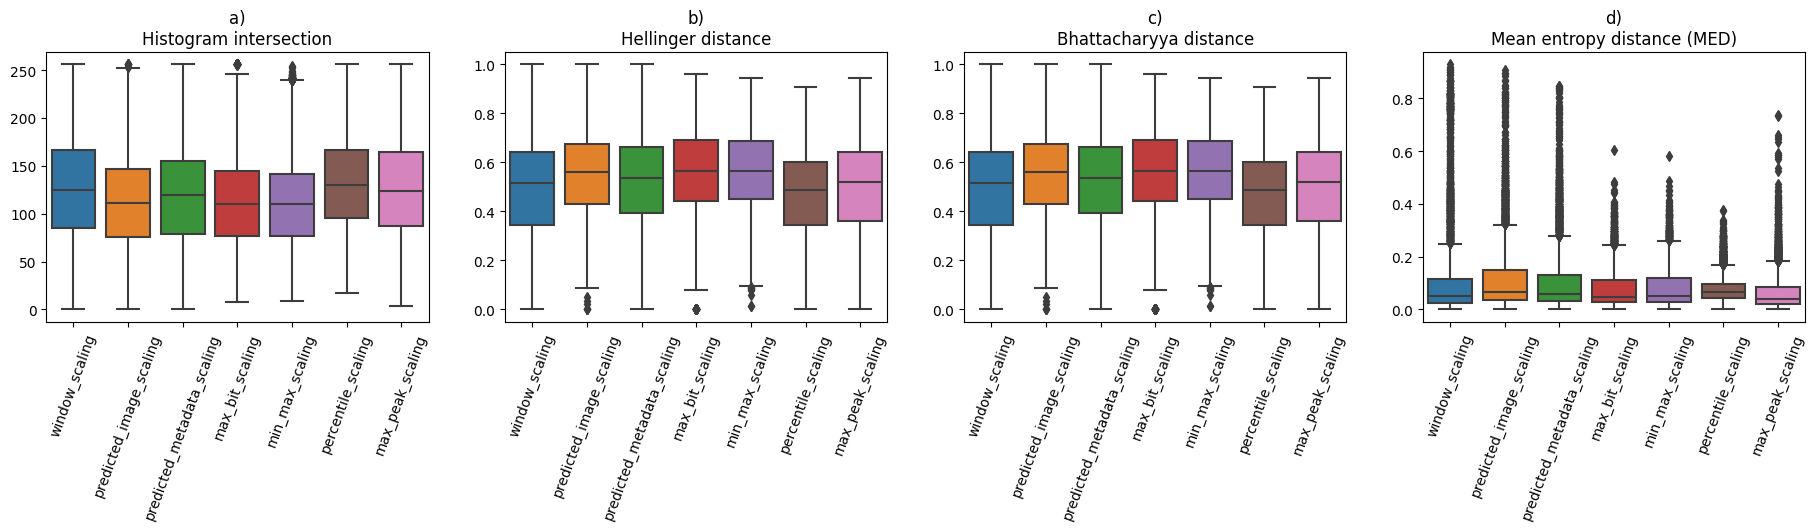

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=((22.7, 3.5)))
for i in range(4):
  axes[i].tick_params(axis='x', rotation=70)
sns.boxplot(data=int_df/16384*256, ax=axes[0]).set(title='a)\nHistogram intersection')
sns.boxplot(data=hel_df, ax=axes[1]).set(title='b)\nHellinger distance')
sns.boxplot(data=bha_df, ax=axes[2]).set(title='c)\nBhattacharyya distance')
sns.boxplot(data=med_df, ax=axes[3]).set(title='d)\nMean entropy distance (MED)')

In [ ]:
from scipy.stats import f_oneway
anova_intersect = f_oneway(np.array(int_df['window_scaling']),
                            np.array(int_df['predicted_image_scaling']),
                            np.array(int_df['predicted_metadata_scaling']),
                            np.array(int_df['max_bit_scaling']),
                            np.array(int_df['min_max_scaling']),
                            np.array(int_df['percentile_scaling']),
                            np.array(int_df['max_peak_scaling']))
anova_hellinger = f_oneway(np.array(hel_df['window_scaling']),
                           np.array(hel_df['predicted_image_scaling']),
                           np.array(hel_df['predicted_metadata_scaling']),
                           np.array(hel_df['max_bit_scaling']),
                           np.array(hel_df['min_max_scaling']),
                           np.array(hel_df['percentile_scaling']),
                           np.array(hel_df['max_peak_scaling']))
anova_bhattacharyya = f_oneway(np.array(bha_df['window_scaling']),
                               np.array(bha_df['predicted_image_scaling']),
                               np.array(bha_df['predicted_metadata_scaling']),
                               np.array(bha_df['max_bit_scaling']),
                               np.array(bha_df['min_max_scaling']),
                               np.array(bha_df['percentile_scaling']),
                               np.array(bha_df['max_peak_scaling']))
anova_med = f_oneway(np.array(med_df['window_scaling']),
                     np.array(med_df['predicted_image_scaling']),
                     np.array(med_df['predicted_metadata_scaling']),
                     np.array(med_df['max_bit_scaling']),
                     np.array(med_df['min_max_scaling']),
                     np.array(med_df['percentile_scaling']),
                     np.array(med_df['max_peak_scaling']))

print("INTERSECTION:          ", anova_intersect)
print("HELLINGER:             ", anova_hellinger)
print("BHATTACHARYYA:         ", anova_bhattacharyya)
print("MEAN ENTROPY DISTANCE: ", anova_med)

INTERSECTION:           F_onewayResult(statistic=107.83262978962728, pvalue=3.256477387954301e-135)
HELLINGER:              F_onewayResult(statistic=138.68821619144165, pvalue=2.335052773456218e-174)
BHATTACHARYYA:          F_onewayResult(statistic=138.68821619144165, pvalue=2.335052773456218e-174)
MEAN ENTROPY DISTANCE:  F_onewayResult(statistic=201.2599590672536, pvalue=3.144321327792019e-253)


In [ ]:
def make_list(df):
  mylist = []
  for col in df.columns:
    mylist += df[col].tolist()
  return mylist


make_list(int_df)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_intersect = pairwise_tukeyhsd(endog=make_list(int_df), groups=np.repeat(['window_scaling', 'predicted_image_scaling', 'predicted_metadata_scaling', 'max_bit_scaling', 'min_max_scaling', 'percentile_scaling', 'max_peak_scaling'], repeats=len(x_test)), alpha=0.05)
tukey_hellinger = pairwise_tukeyhsd(endog=make_list(hel_df), groups=np.repeat(['window_scaling', 'predicted_image_scaling', 'predicted_metadata_scaling', 'max_bit_scaling', 'min_max_scaling', 'percentile_scaling', 'max_peak_scaling'], repeats=len(x_test)), alpha=0.05)
tukey_bhatta = pairwise_tukeyhsd(endog=make_list(bha_df), groups=np.repeat(['window_scaling', 'predicted_image_scaling', 'predicted_metadata_scaling', 'max_bit_scaling', 'min_max_scaling', 'percentile_scaling', 'max_peak_scaling'], repeats=len(x_test)), alpha=0.05)
tukey_med = pairwise_tukeyhsd(endog=make_list(med_df), groups=np.repeat(['window_scaling', 'predicted_image_scaling', 'predicted_metadata_scaling', 'max_bit_scaling', 'min_max_scaling', 'percentile_scaling', 'max_peak_scaling'], repeats=len(x_test)), alpha=0.05)
print("Histogram Intersection:\n", tukey_intersect)
print("Hellinger distance:\n", tukey_hellinger)
print("Bhattacharyya distance:\n", tukey_bhatta)
print("Mean entropy distance:\n", tukey_med)

Histogram Intersection:
                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
          group1                     group2            meandiff  p-adj    lower      upper    reject
----------------------------------------------------------------------------------------------------
           max_bit_scaling           max_peak_scaling   771.7652    0.0   571.8193    971.711   True
           max_bit_scaling            min_max_scaling  -133.4788  0.435  -333.4247    66.4671  False
           max_bit_scaling         percentile_scaling  1100.0379    0.0    900.092  1299.9838   True
           max_bit_scaling    predicted_image_scaling  -208.8288 0.0339  -408.7747     -8.883   True
           max_bit_scaling predicted_metadata_scaling   117.4547 0.5944   -82.4912   317.4006  False
           max_bit_scaling             window_scaling   536.3638    0.0   336.4179   736.3097   True
          max_peak_scaling            min_max_scaling   -905.244  

# Images for Paper

In [ ]:
# Windowing DEMO
id = y_test.index[1]
test_orig = np.array(PilImage.open(os.path.join(ORIGINALPNG, str(id) + '.png')))
test_windowcrop = np.array(PilImage.open(os.path.join(WINDOWCROP, str(id) + '.png')))
windowcenter = y_test["WindowCenter"].loc[id]
windowwidth = y_test["WindowWidth"].loc[id]

fig, ax = plt.subplots()
plt.hist(test_orig.ravel(), np.max(test_orig))
plt.axvline(x=windowcenter, color='black', linestyle='-', label="WindowLevel")
plt.axvline(x=windowcenter - windowwidth/2, color='black', linestyle='--', label="- WindowWidth")
plt.axvline(x=windowcenter + windowwidth/2, color='black', linestyle='--', label="+ WindowWidth")
ax.axvspan(windowcenter - windowwidth/2, windowcenter + windowwidth/2, alpha=.4, color='red', label="Area of interest")
plt.title("Applied window level and width")
plt.xlabel("Pixel intensity value")
plt.ylabel("Number of pixels")
plt.legend()
plt.show()

#plt.hist(test_windowcrop.ravel(), 256, [0, np.max(test_orig)])

In [ ]:
# Entropy DEMO

#Show entropy images
entropy_img = entropy(img_as_ubyte(test_windowcrop), disk(3))
plt.title("Pixels' local entropy of scaled pixel data")
imshow(entropy_img)
entropy_img.max()


# Show entropy historgams
plt.hist(entropy_img.ravel(), 500, [0, 5])
plt.title("Histogram of entropy values")
plt.xlabel("Entropy value")
plt.ylabel("Number of pixels")
plt.show()